In [1]:
from matplotlib import pyplot as plt
from matplotlib.colors import Normalize
import nest
import numpy as np
import itertools
import pickle
import time
from scipy.signal import savgol_filter
from sklearn.decomposition import FastICA, PCA, KernelPCA, SparsePCA
from sklearn.metrics import explained_variance_score

In [2]:
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['figure.figsize'] = (6,4)
new_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']

# Loading the data

In [3]:
folder = 'saved_experiments'
# load_file_name = 'experiment_dump_2018-11-28T18:31:21'
load_file_name = 'experiment_dump'
with open('{}/{}.pickle'.format(folder, load_file_name), 'rb') as f:
    data = pickle.load(f)
    
    S_msn = []
    S_snr = []
    resolution = data['signal_hd_msn'].shape[0]
    for x in range(resolution):
        for y in range(resolution):
            S_msn.append(data['signal_hd_msn'][x,y,0,1500:-100])
            S_snr.append(data['signal_hd_snr'][x,y,1,1500:-100])
    S_msn = np.c_[S_msn].T
    S_snr = np.c_[S_snr].T

x = np.linspace(-1000,950,num=1950)

## Preview

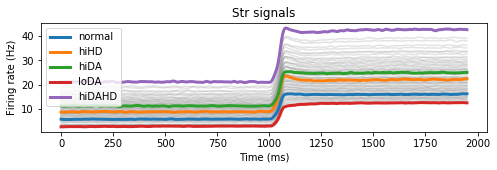

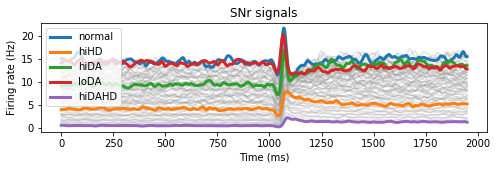

In [4]:
def get_cases(S):
    s = []
    s.append(S[:, 2*8+0])
    s.append(S[:, 2*8+7])
    s.append(S[:, 7*8+0])
    s.append(S[:, 0*8+0])
    s.append(S[:, 7*8+7])
    return s
s_msn = get_cases(S_msn)
s_snr = get_cases(S_snr)
labels = ['normal', 'hiHD', 'hiDA', 'loDA', 'hiDAHD']


def plot_all_cases(title, S, s, labels, size=(8,2), alpha=0.25, greytone='#909090', linewidth=3.0):
    S = np.array([]) if S is None else S
    plt.rcParams['figure.figsize'] = size
    _=plt.figure(); plt.title(title)
    plt.plot(S, alpha=alpha, color=greytone)
    for signal, label in zip(s, labels):
        plt.plot(signal, label=label, linewidth=linewidth)
    _=plt.legend(loc='upper left')
    plt.xlabel('Time (ms)')
    plt.ylabel('Firing rate (Hz)')

plot_all_cases('Str signals', S_msn, s_msn, labels); plt.savefig("str_signals.svg")
plot_all_cases('SNr signals', S_snr, s_snr, labels); plt.savefig("snr_signals.svg")

## Pre-processing data

In [5]:
pS_msn = S_msn.copy()
pS_snr = S_snr.copy()
pS_msn -= np.mean(pS_msn[:1000,:], axis=0)
pS_msn /= np.std(pS_msn, axis=0)
pS_snr -= np.mean(pS_snr[:1000,:], axis=0)
pS_snr /= np.std(pS_snr, axis=0)

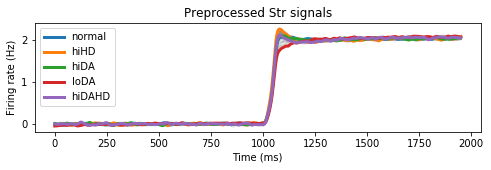

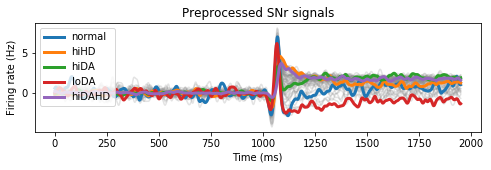

In [6]:
ps_msn = get_cases(pS_msn)
ps_snr = get_cases(pS_snr)

plot_all_cases('Preprocessed Str signals', pS_msn, ps_msn, labels); plt.savefig("str_processed_signals.svg")
plot_all_cases('Preprocessed SNr signals', pS_snr, ps_snr, labels); plt.savefig("snr_processed_signals.svg")

# Explained variance by # of components

In [7]:
from sklearn.metrics import explained_variance_score

/home/alvaro/.local/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning:FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.


[(1, 0.9993503620856301), (2, 0.9997617583161276), (3, 0.9998033812416972), (4, 0.9998217572059351), (5, 0.9998313186057876), (6, 0.9998399073651847), (7, 0.9998482361294732), (8, 0.9998560760279449), (9, 0.999863189023564)]


/home/alvaro/.local/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning:FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.


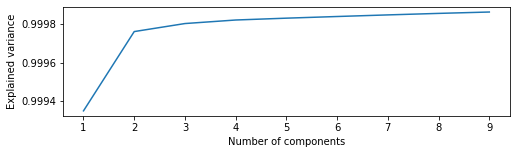

In [8]:
variance_score = []
n_components = []
for n in range(1,10):
    n_components.append(n)
    ica = FastICA(n_components=n, random_state=0)
    S_ = ica.fit_transform(pS_msn)
    A_ = ica.mixing_  # Get estimated mixing matrix
    pS_msn_pred = np.dot(S_, A_.T) + ica.mean_
    variance_score.append(explained_variance_score(pS_msn, pS_msn_pred))

plt.plot(n_components, variance_score)
plt.xlabel("Number of components")
plt.ylabel("Explained variance")
print(list(zip(n_components, variance_score)))

/home/alvaro/.local/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning:FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
/home/alvaro/.local/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning:FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
/home/alvaro/.local/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning:FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.


[(1, 0.7289890834262038), (2, 0.8536961897124077), (3, 0.9130416604660917), (4, 0.9201175440064269), (5, 0.9270566407888907), (6, 0.9334556152958157), (7, 0.93912080309778), (8, 0.9440045316465575), (9, 0.9483544845824061)]


/home/alvaro/.local/lib/python3.7/site-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning:FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.


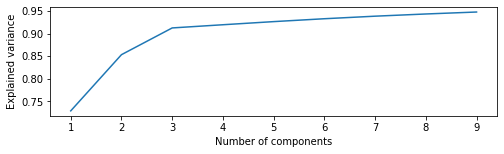

In [9]:
variance_score = []
n_components = []
for n in range(1,10):
    n_components.append(n)
    ica = FastICA(n_components=n, random_state=0, max_iter=5000)
    S_ = ica.fit_transform(pS_snr)
    A_ = ica.mixing_  # Get estimated mixing matrix
    pS_snr_pred = np.dot(S_, A_.T) + ica.mean_
    variance_score.append(explained_variance_score(pS_snr, pS_snr_pred))

plt.plot(n_components, variance_score)
plt.xlabel("Number of components")
plt.ylabel("Explained variance")

print(list(zip(n_components, variance_score)))

# Using ICA to extract IC explaining at least 90% of variance and with at least 2 components

In [10]:
ica_msn = FastICA(n_components=2, random_state=4)
ica_snr = FastICA(n_components=3, random_state=0)

def get_normalized_ic(ica, pS):
    C = ica.fit_transform(pS)
    M = ica.mixing_.copy()
    C *= np.max(M, axis=0)
    M /= np.max(M, axis=0)    
    M = M.reshape((8,8, ica.n_components))
    return C, M

C_msn, M_msn = get_normalized_ic(ica_msn, pS_msn)
C_snr, M_snr = get_normalized_ic(ica_snr, pS_snr)

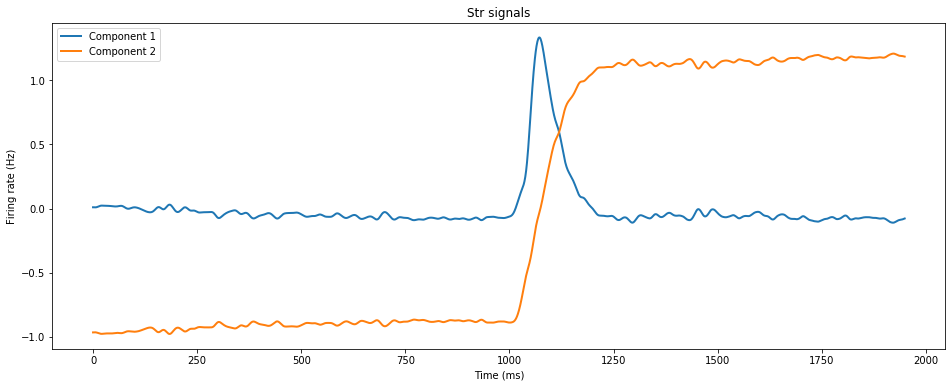

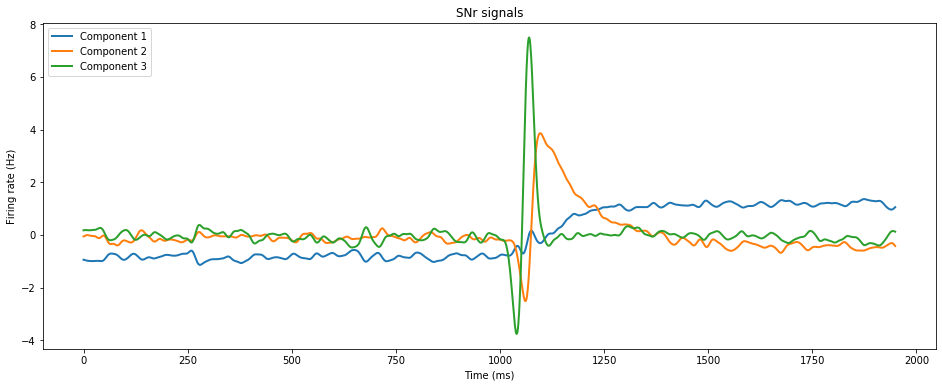

In [11]:
plt.rcParams['figure.figsize'] = (8,4)

plot_all_cases(
    'Str signals', None, C_msn.T, 
    ['Component {}'.format(i+1) for i in range(ica_msn.n_components)], linewidth=2.0,
    size=(16,6)
)

plot_all_cases(
    'SNr signals', None, C_snr.T, 
    ['Component {}'.format(i+1) for i in range(ica_snr.n_components)], linewidth=2.0,
    size=(16,6)
)

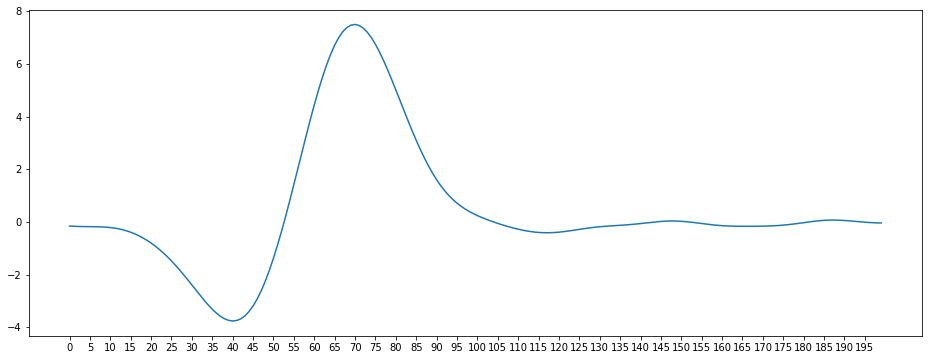

In [12]:
_=plt.plot(range(200), C_snr[1000:1200,2])
_=plt.xticks(range(0,200,5))

/home/alvaro/.local/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning:No contour levels were found within the data range.
/home/alvaro/.local/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning:No contour levels were found within the data range.


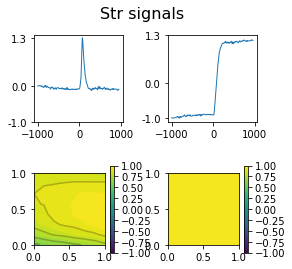

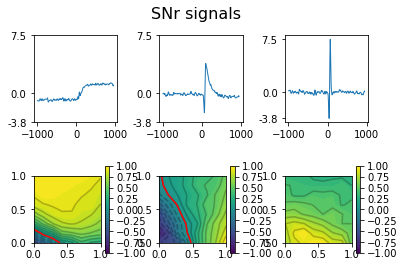

In [13]:
from matplotlib.pyplot import FormatStrFormatter

def plot_components(title, ica, C, M):
    plt.rcParams['figure.figsize'] = (2*ica.n_components,4)
    figure = plt.figure()
    plt.suptitle(title, size=16)
    plt.subplots_adjust(wspace=0.5, hspace=0.5)
    for i in range(ica.n_components):
        ax = plt.subplot(2, ica.n_components, 1 + i)
        plt.plot(x, C[:,i], label='Component {}'.format(i+1), linewidth=1.0)
        plt.yticks([np.min(C[:,:]), np.max(C[:,:]), 0])
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    for i in range(ica.n_components):
        main_ax = plt.subplot(2, ica.n_components, 1 + i + ica.n_components)
#         cax = main_ax.contourf(M[:,:,i])
        cax = main_ax.contourf(M[:,:,i], levels=np.linspace(-1,1,num=41), extent=[0,1,0,1], norm=Normalize(-1,1))
#         cax = main_ax.contourf(M[:,:,i], levels=10, extent=[0,1,0,1])
        cax.ax.set_aspect('equal')
        plt.colorbar(cax)
#         cax.set_clim(-1,1)
        main_ax.contour(M[:,:,i], levels=np.linspace(-1,1,num=21), extent=[0,1,0,1], colors=('black'), alpha=0.25)
        main_ax.contour(M[:,:,i], levels=[0], colors=('r'), extent=[0,1,0,1])
        plt.yticks(np.linspace(0,1,3))
        plt.xticks(np.linspace(0,1,3))
#         main_ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))


plot_components('Str signals', ica_msn, C_msn, M_msn); plt.savefig("str_ica.svg")
plot_components('SNr signals', ica_snr, C_snr, M_snr); plt.savefig("snr_ica.svg")

# PCA vs ICA comparison

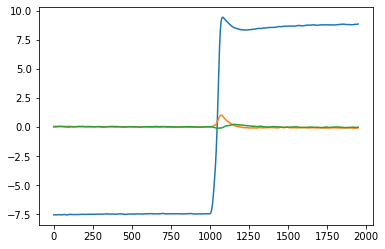

In [14]:
pca = PCA(n_components=3, random_state=4)
C = pca.fit_transform(pS_msn)
plt.plot(C)

In [15]:
pca = PCA(n_components=3, whiten=True, random_state=4)
C = pca.fit_transform(pS_snr)

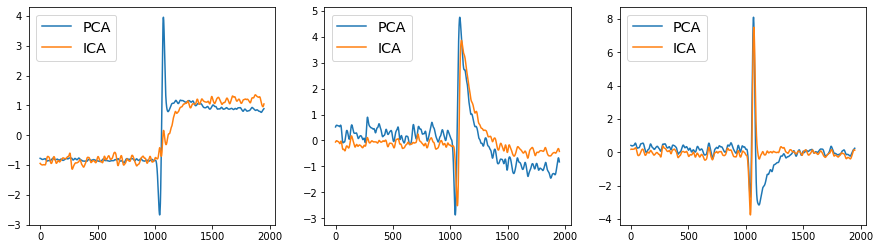

In [16]:
plt.rcParams['figure.figsize'] = (15,4)
fig = plt.figure()

ax=plt.subplot(131)
plt.plot(C[:,0], label="PCA")
plt.plot(C_snr[:,0], label="ICA")
legend = ax.legend(loc='upper left', fontsize='x-large')

ax=plt.subplot(132)
plt.plot(C[:,2], label="PCA")
plt.plot(C_snr[:,1], label="ICA")
legend = ax.legend(loc='upper left', fontsize='x-large')

ax=plt.subplot(133)
plt.plot(C[:,1], label="PCA")
plt.plot(C_snr[:,2], label="ICA")
legend = ax.legend(loc='upper left', fontsize='x-large')